<a href="https://colab.research.google.com/github/jccc2002/StructuredProgramming2A/blob/master/predictor_from_scratch_JCCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("dataset.csv", index_col=0, sep=',', encoding='latin-1')
df_null = df.isnull().sum().sum()


print('null cells:',df_null)


null cells: 305


In [ ]:
columnMissing = df.isnull().sum()
# Determine No. cells with null values
columnsNull = columnMissing[columnMissing > 0].count()

print('Cells with null values:', columnsNull)

Cells with null values: 56


In [ ]:
categorical_columns = ['gdo_rezsoc00', 'gdo_rezsoc05', 'gdo_rezsoc10']
df_columns = df[categorical_columns]
print(df_columns)

    gdo_rezsoc00 gdo_rezsoc05 gdo_rezsoc10
ent                                       
1       Muy bajo     Muy bajo     Muy bajo
1       Muy bajo     Muy bajo     Muy bajo
1       Muy bajo     Muy bajo     Muy bajo
1       Muy bajo     Muy bajo     Muy bajo
1       Muy bajo     Muy bajo     Muy bajo
..           ...          ...          ...
32         Medio         Bajo         Bajo
32      Muy bajo     Muy bajo     Muy bajo
32      Muy bajo     Muy bajo     Muy bajo
32          Bajo         Bajo     Muy bajo
32           NaN         Bajo     Muy bajo

[2456 rows x 3 columns]


In [ ]:
# Data imputation
def fill_na_with_group_mean(group): # numeric
    return group.fillna(group.mean(numeric_only=True))

def fill_na_non_numeric_with_group_mean(group): # non-numeric
    for col in group.columns:
        if pd.api.types.is_numeric_dtype(group[col].dtype):
            group_mean = group[col].mean()
            group[col] = group[col].fillna(group_mean)
    return group


grouped = df.groupby('nom_ent',group_keys=True)
df = grouped.apply(fill_na_with_group_mean) # Apply the function to the grouped data


df = pd.get_dummies(df, columns=['gdo_rezsoc00','gdo_rezsoc05', 'gdo_rezsoc10']) # For non-numerical
grouped = df.groupby(['ent'],group_keys=True)
df = grouped.apply(fill_na_non_numeric_with_group_mean)

print("Total cells with null values:", df.isnull().sum().sum()) # #total cells with nulls after imputation

Total cells with null values: 0


In [ ]:
correlation_matrix = df.corr(numeric_only=True)
target_correlation = correlation_matrix['N_pobreza'].sort_values(ascending=False)

# Correlation values
print(target_correlation)

N_pobreza                 1.000000
N_plb                     0.996157
N_pobreza_m               0.991047
N_ic_segsoc               0.982795
N_carencias               0.978825
                            ...   
carencias                -0.377503
porc_pob15_basicainc05   -0.382867
porc_pob15_basicainc00   -0.392885
perrankin_pe             -0.500170
perrankin_p              -0.524888
Name: N_pobreza, Length: 148, dtype: float64


In [ ]:
  correlation_matrix = df.corrwith(df['N_pobreza'], numeric_only=True)

  # Plot correlation values with using heat map
  plt.figure(figsize=(100, 100))
  sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap="coolwarm", cbar=False, fmt=".2f")
  plt.title("Matriz de Correlación con 'N_pobreza'")
  plt.show()

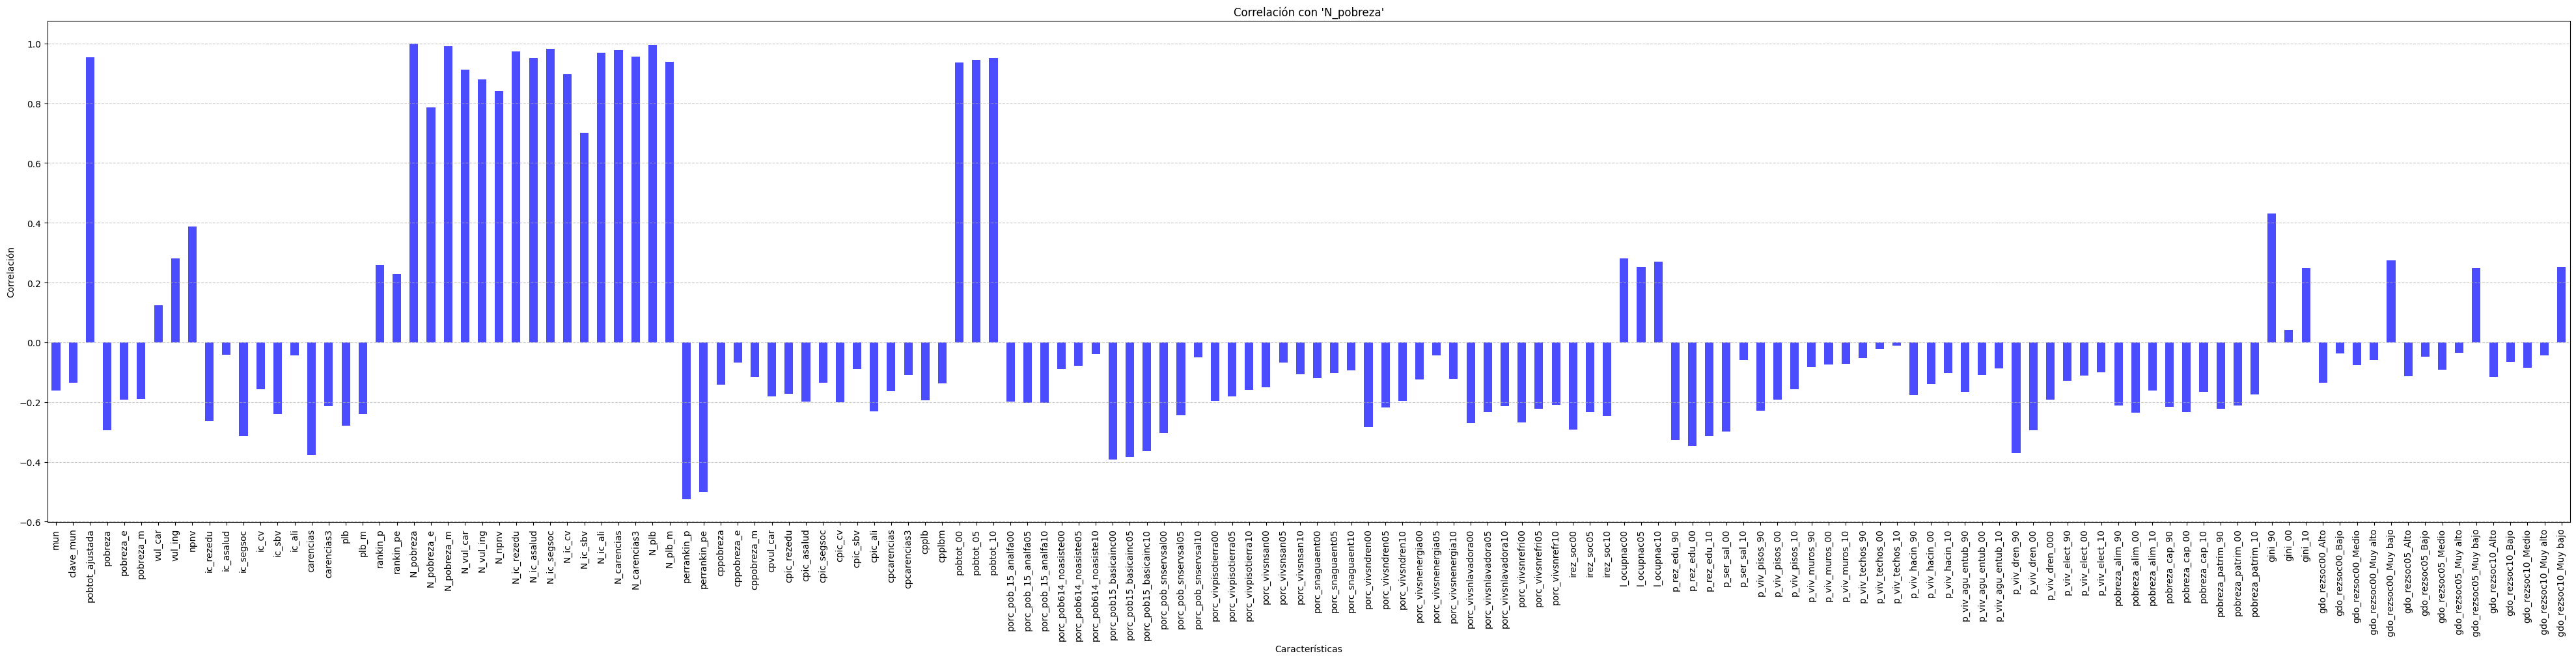

In [ ]:
correlation_matrix = df.corrwith(df['N_pobreza'], numeric_only=True)

# Validation of previous values using map heat regarding the target value
plt.figure(figsize=(50, 10))
correlation_matrix.plot(kind='bar', color='b', alpha=0.7)
plt.title("Correlación con 'N_pobreza'")
plt.xlabel("Características")
plt.ylabel("Correlación")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [ ]:
numeric_columns = df.select_dtypes(include=np.number).columns

# Parameter inputation
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Using the parameters, determine the outliers
outliers = (df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))

# Remove outliers
df = df[~outliers.any(axis=1)]


In [ ]:
# Characteristics & target definition
X = df[['pobtot_ajustada','N_pobreza_e', 'N_pobreza_m', 'N_vul_car','N_vul_ing','N_npnv','N_ic_rezedu','N_ic_asalud','N_ic_segsoc','N_ic_cv','N_ic_sbv','N_carencias','N_carencias3','N_plb','N_plb_m','pobtot_00','pobtot_05','pobtot_10','gini_90']].values
y = df['N_pobreza'].values

# Traning and testing division
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# To add a column of ones for the bias term.
X_train = np.c_[np.ones(X_train.shape[0]), X_train]

# Calculate coefficients using OLS (Ordinary Least Squares)
coefficients = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

# Predictions using the testing values
X_test = np.c_[np.ones(X_test.shape[0]), X_test]
y_pred = X_test.dot(coefficients)

# Calculate Mean Square Error (MSE)
mse = np.mean((y_pred - y_test) ** 2)

# Coefficient of Determination calculation  (R^2)
y_mean = np.mean(y_test)
sst = np.sum((y_test - y_mean) ** 2)
ssr = np.sum((y_test - y_pred) ** 2)
r2 = 1 - (ssr / sst)

print('Mean Square Error:', mse)
print('Coefficient of Determination (R^2):', r2)


Mean Square Error: 0.2591360712940919
Coefficient of Determination (R^2): 0.9999999914382595


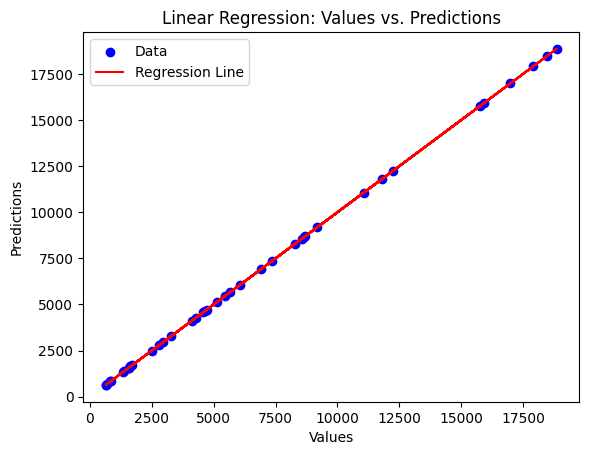

In [ ]:
plt.scatter(y_test, y_pred, color='blue', label='Data')
plt.plot(y_test, y_test, color='red', label='Regression Line')
plt.xlabel('Values')
plt.ylabel('Predictions')
plt.title('Linear Regression: Values vs. Predictions')
plt.legend()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Mean Square Error: 0.1499972172902587
Coefficient of Determination (R^2): 0.9999999938534392


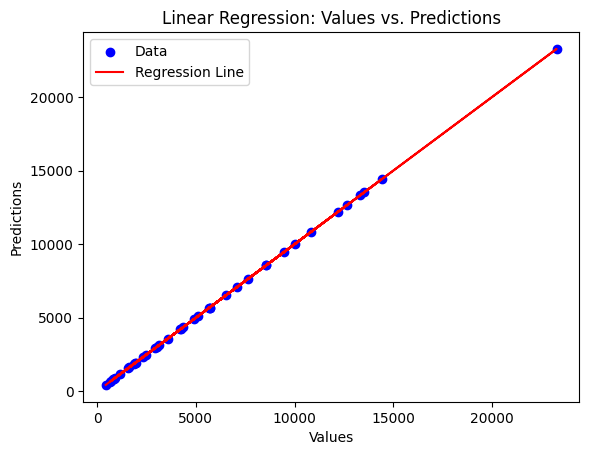

In [ ]:
X = df[['pobtot_ajustada', 'N_pobreza_e', 'N_pobreza_m', 'N_vul_car', 'N_vul_ing', 'N_npnv', 'N_ic_rezedu', 'N_ic_asalud', 'N_ic_segsoc', 'N_ic_cv', 'N_ic_sbv', 'N_carencias', 'N_carencias3', 'N_plb', 'N_plb_m', 'pobtot_00', 'pobtot_05', 'pobtot_10', 'gini_90']]
y = df['N_pobreza']

# Data division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regresion Model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Mean Square Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Coefficient of Determination (R^2)
r2 = r2_score(y_test, y_pred)

print('Mean Square Error:', mse)
print('Coefficient of Determination (R^2):', r2)

# Crear un gráfico de dispersión
plt.scatter(y_test, y_pred, color='blue', label='Data')
plt.plot(y_test, y_test, color='red', label='Regression Line')
plt.xlabel('Values')
plt.ylabel('Predictions')
plt.title('Linear Regression: Values vs. Predictions')
plt.legend()
plt.show()
